In [53]:
from pymongo import MongoClient
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
pd.set_option('display.max_columns', None)
pd.set_option('display.float_format', '{:.4f}'.format)

In [54]:
# client = MongoClient("mongodb://13.127.57.185:27017/")
# client.list_database_names()
# db = client['pvvnl']
# db.list_collection_names()
# collection = db["load_profile_jdvvnl"]
# data = collection.find({'sensor_id': '0000e2fc-8dad-4d82-9da6-88695cc94265'})
# l = []
# for _ in data:
#     l.append(_)
#     # print(_)
# df = pd.DataFrame(l)
# df

In [55]:
df = pd.read_csv("single_feeder_data_jdvvnl.csv", low_memory=False)
df = df[['sensor_id', 'instant_cum_KW', 'instant_cum_KVA', 'R_Voltage',
       'Y_Voltage', 'B_Voltage', 'R_Current', 'Y_Current', 'B_Current', 'R_PF',
       'Y_PF', 'B_PF', 'cumm_PF', 'status', 'date',
       'creation_time', 'opening_KWh', 'opening_KVAh', 'closing_KWh',
       'closing_KVAh', 'count'
       ]]
dff = df[df['status']=="P"]
cols_to_divide = ['instant_cum_KW', 'instant_cum_KVA', 'R_Voltage', 'Y_Voltage', 'B_Voltage', 
                  'R_Current', 'Y_Current', 'B_Current', 'R_PF', 'Y_PF', 'B_PF', 'cumm_PF']

# Ensure you're using .loc to modify the original dataframe
dff.loc[:, cols_to_divide] = dff[cols_to_divide].apply(lambda x: x / dff['count'], axis=0)
data = dff[["creation_time",'instant_cum_KW']]
data.reset_index(drop=True ,inplace=True)
data = data.copy()  # Create a copy
data.rename(columns={"instant_cum_KW":'Load_kW'},inplace=True)
data['creation_time'] = pd.to_datetime(data['creation_time'])
data.set_index('creation_time',drop=True,inplace=True)
data = data.loc[data.index>pd.to_datetime("2023-10-01 00:00:00")]
data

,Load_kW
creation_time,
2023-10-01 00:15:00,19.9233
2023-10-01 00:30:00,19.9911
2023-10-01 00:45:00,19.7322
2023-10-01 01:00:00,20.2622
2023-10-01 01:15:00,19.8744
...,...
2024-03-30 22:45:00,10.4722
2024-03-30 23:00:00,10.3067
2024-03-30 23:15:00,10.0856


at start:  Load_kW    192
dtype: int64
at end:  Load_kW    0
dtype: int64


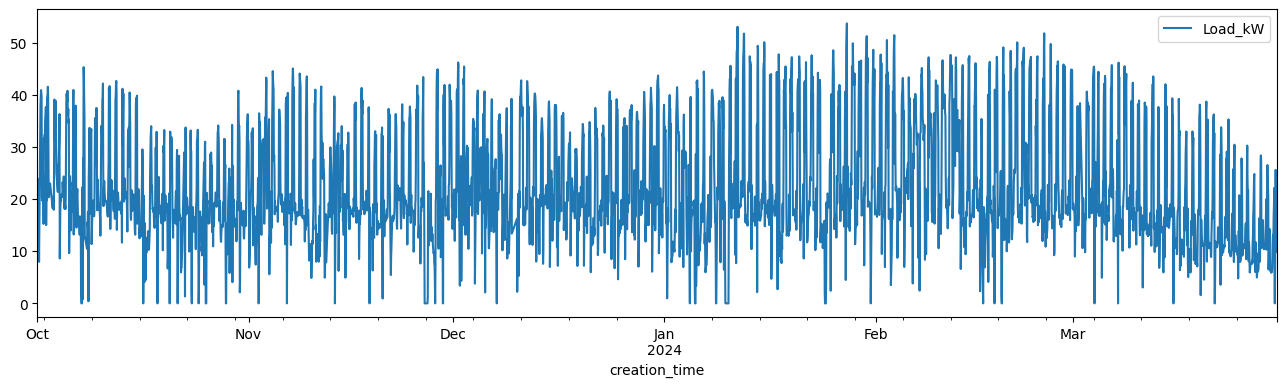

,Load_kW
creation_time,
2023-10-01 00:00:00,19.8822
2023-10-01 01:00:00,19.9639
2023-10-01 02:00:00,20.1197
2023-10-01 03:00:00,20.2728
2023-10-01 04:00:00,23.8996
...,...
2024-03-30 19:00:00,10.3994
2024-03-30 20:00:00,11.5158
2024-03-30 21:00:00,12.2079


In [56]:
# resample_df = data.resample(rule="15 min").asfreq()
resample_df = data.resample(rule="1h").mean()
print("at start: ",resample_df.isna().sum())
# Fill NaN values in each column with the mean of that column
# resample_df = resample_df.fillna(resample_df.mean())
resample_df.interpolate(method="linear", inplace=True)
print("at end: ",resample_df.isna().sum())
plt.figure(figsize=(16, 4))
resample_df.plot(ax=plt.gca())  # This uses the current axes
# plt.title(col)
plt.show()
resample_df

In [57]:
import os
from logger import logger
import joblib
import pickle
from xgboost import XGBRegressor
from sklearn.model_selection import RandomizedSearchCV, train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from math import sqrt
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from sklearn.preprocessing import MinMaxScaler
import numpy as np
class testing:
    def add_lags(self, dff, target_col, large_data= False):
        try:
            # target_map = dff['consumed_unit'].to_dict()
            target_map = dff[target_col].to_dict()

            # 1 Hour, 2 Hours, 6 Hours
            dff['lag1_hour']   =  (dff.index - pd.Timedelta('1 hour')).map(target_map)
            dff['lag2_hours']  =  (dff.index - pd.Timedelta('2 hours')).map(target_map)
            dff['lag3_hours']  =  (dff.index - pd.Timedelta('3 hours')).map(target_map)
            dff['lag6_hours']  =  (dff.index - pd.Timedelta('6 hours')).map(target_map)
            # dff['lag12_hours'] =  (dff.index - pd.Timedelta('12 hours')).map(target_map)
            dff['lag1_day']    =  (dff.index - pd.Timedelta('1 day')).map(target_map)
            dff['lag2_days']   =  (dff.index - pd.Timedelta('2 days')).map(target_map)
            dff['lag3_days']   =  (dff.index - pd.Timedelta('3 days')).map(target_map)
            dff['lag7_days']   =  (dff.index - pd.Timedelta('7 days')).map(target_map)

            # if large_data:
            dff['lag_15_day'] = (dff.index - pd.Timedelta('15 days')).map(target_map)
            dff['lag_30_day'] = (dff.index - pd.Timedelta('30 days')).map(target_map)
            # dff['lag_45_day'] = (dff.index - pd.Timedelta('45 days')).map(target_map)
            logger.info(f"lags added")
            return dff
        
        except KeyError as e:
            logger.error(f"Error: {e}. 'consumed_unit' column not found in the DataFrame.",exc_info=True)
        except Exception as ex:
            logger.error(f"An unexpected error occurred: {ex}",exc_info= True)


    def create_features(self,hourly_data,lagre_data= False):
        try:
            hourly_data = hourly_data.copy()
            # Check if the index is in datetime format
            if not isinstance(hourly_data.index, pd.DatetimeIndex):
                hourly_data.index = pd.to_datetime(hourly_data.index)
            
            hourly_data['hour'] = hourly_data.index.hour
            hourly_data['day'] = hourly_data.index.day
            hourly_data['dayofweek'] = hourly_data.index.dayofweek
            hourly_data['weekofyear'] = hourly_data.index.isocalendar().week
            hourly_data['hour'] = hourly_data.index.hour
            hourly_data['dayofweek'] = hourly_data.index.dayofweek
            hourly_data['dayofyear'] = hourly_data.index.dayofyear
            hourly_data['is_weekend'] = hourly_data['dayofweek'].isin([5, 6]).astype(int)
            hourly_data['holiday'] = 0
            # if lagre_data:
            hourly_data['month'] = hourly_data.index.month
            hourly_data['quarter'] = hourly_data.index.quarter
            hourly_data['weekofyear'] = hourly_data.index.isocalendar().week
            hourly_data['year'] = hourly_data.index.year
        
            return hourly_data

        except Exception as e:
            logger.info(f"error in feature creation: {e}",exc_info= True)

    def scaling_layer(self,dataset,target_variable= "Load_kW"):
        try:
            scaler = MinMaxScaler()
            # Exclude the "Load_kW" column from features to normalize
            features_to_normalize = [col for col in dataset.columns if col != target_variable]
        
            dataset[features_to_normalize] = scaler.fit_transform(dataset[features_to_normalize])
            with open('saved_model/minmax_scaler.pkl', 'wb') as f:
                pickle.dump(scaler, f)
            return dataset
        
        except Exception as e:
            logger.error(f"error in scaling: {e}",exc_info= True) 

    def data_split_function(self,dataset, target_variable= "Load_kW"):
        """
            Splits the given dataset into training and testing sets, separating features and the target variable.

            Args:
                dataset (pandas.DataFrame): The dataset containing both features and the target variable.
                target_variable (str): The name of the column representing the target variable to be predicted. Default is 'Load_kW'.

            Returns:
                X_train (pandas.DataFrame): Training set features.
                X_test (pandas.DataFrame): Testing set features.
                y_train (pandas.Series): Training set target variable.
                y_test (pandas.Series): Testing set target variable.
            
            Raises:
                Exception: If there's an issue during the data split, an error message is logged.

            Example:
                >>> df = pd.DataFrame({...})
                >>> X_train, X_test, y_train, y_test = obj.data_split(df, target_variable="Load_kW")
        """
        try:
            n = len(dataset)
            train_df = dataset[0:int(n*0.9)]
            test_df = dataset[int(n*0.9):]
            train_dataset, test_dataset = train_df.copy(),test_df.copy() #,val_df.copy()
            # train_labels = train_features.pop(target_variable)
            # test_labels = test_features.pop(target_variable)
            
            # print(f"train_features shape:{train_features.shape},train_label shape: {train_labels.shape}")
            # print(f"test_features shape:{test_features.shape} ,test_label shape: {test_labels.shape}")
            logger.info(f"data split done")
            # logger.info(f"train_features shape:{train_features.shape} ,train_label shape: {train_labels.shape}")
            # logger.info(f"test_features shape:{test_features.shape} ,test_label shape: {test_labels.shape}")
            logger.info(f"train_features shape:{train_dataset.shape}")
            logger.info(f"test_features shape:{test_dataset.shape}")

            return train_dataset,test_dataset
            # return train_features,test_features,train_labels, test_labels
        
        except Exception as e:
            logger.error(f"error in split: {e}",exc_info=True)


    def model_trainer(self, train_dataset, target_variable, random_state=True, model_name=None):
            try:
                # noramlizing data
                dataset_scalled = self.scaling_layer(dataset=train_dataset)

                # Split the dataset into training and test sets using train test split function with randomizing data
                if random_state:            
                    # dataset_labels = dataset_scalled.pop(target_variable)
                    train_features, test_features, train_label, test_label = self.data_split(dataset_scalled)    
                
                else:    
                    # Split the dataset into training and test sets using custom data split function without randomizing data
                    train_features, test_features = self.data_split_function(dataset=dataset_scalled)
                    train_label = train_features.pop(target_variable)
                    test_label = test_features.pop(target_variable)
                
                os.makedirs('saved_model/test', exist_ok=True)
                if model_name == "RFR":
                    # Step 4: Initialize the RandomForestRegressor model
                    model= self.random_forest_regressor(train_features=train_features,
                                                        train_label=train_label)
                    logger.info(f"model trained : RandomForestRegressor")
                    self.prediction(model= model,
                                input_data= test_features,
                                scoring= True,
                                test_data= test_label)
                    
                    # Save the model to a file
                    # joblib.dump(model, 'saved_model/RandomForestRegressor_model.pkl'


                if model_name == "XGboost":
                    model = self.XGboost_model(train_features= train_features,
                                            train_label= train_label)
                    logger.info(f"model trained : XGboost")
                    self.prediction(model= model,
                                input_data= test_features,
                                scoring= True,
                                test_data= test_label)
                    # Save the model to a file
                    # joblib.dump(model, 'saved_model/XGboost_model.pkl')            
                              
                files = os.listdir("saved_model/test")
                if len(files) == 0:
                    model_version = 1  # Start at version 1 if no files are present
                else:
                    model_version = max([int(i.split(".")[1]) for i in files if i.split(".")[1].isdigit()]) + 1
                joblib.dump(model, f"saved_model/test/{model_name}.{model_version}.pkl")
                # model_version=max([int(i) for i in range(len(os.listdir("saved_model/test")+ [0])) ])+1
                # model.save(f"saved_model/test/{model_name}_1.{model_version}")
                return model
            except Exception as e:
                logger.error(f"error in model trainer: {e}",exc_info=True)

    def data_split(self, dataset, target_variable= "Load_kW"): 
        try:
            dataset_features = dataset.copy()
            dataset_label = dataset_features.pop(target_variable)
            # Split the dataset into training and test sets
            train_features, test_features, train_labels, test_labels= train_test_split(dataset_features, dataset_label, test_size=0.1, 
                                                                random_state=42
                                                                )
            logger.info(f"data split done")
            logger.info(f"train_features shape:{train_features.shape} ,train_label shape: {train_labels.shape}")
            logger.info(f"test_features shape:{test_features.shape} ,test_label shape: {test_labels.shape}")
            return train_features, test_features, train_labels, test_labels

        except Exception as e:
            logger.error(f"error in data split: {e}",exc_info=True)  

    def random_forest_regressor(self, train_features, train_label):
        try:
            # model = RandomForestRegressor(n_estimators=100, random_state=42)  # You can tweak hyperparameters
            # model.fit(train_features,train_label)
            param_grid = {
                'n_estimators': [100, 200, 300, 500, 1000],
                'max_depth': [10, 20, 30, 50, None],
                'min_samples_split': [2, 5, 10],
                'min_samples_leaf': [1, 2, 5, 10],
                'max_features': ['auto', 'sqrt', 'log2'],
                'bootstrap': [True, False],
                'n_jobs': [-1]  # Use all cores for faster training
            }

            # Initialize the RandomForestRegressor model
            model = RandomForestRegressor(random_state=42)

            # Perform hyperparameter tuning using RandomizedSearchCV
            random_search = RandomizedSearchCV(estimator=model, param_distributions=param_grid, 
                                            n_iter=10, cv=5, verbose=2, 
                                            scoring='neg_mean_squared_error', random_state=42, n_jobs=-1)
            
            # Fit the RandomizedSearchCV to the data
            random_search.fit(train_features, train_label)
            
            # Get the best parameters
            best_params = random_search.best_params_
            print(f"Best Parameters: {best_params}")
            
            # Train the model with the best parameters
            best_model = RandomForestRegressor(**best_params, random_state=42)
            best_model.fit(train_features, train_label)
            
            logger.info(f"Model trained: RandomForestRegressor with best parameters")
        
            return best_model
        
        except Exception as e:
            logger.error(f"error in random_forest_regressor: {e}", exc_info= True)
    def XGboost_model(self,train_features, train_label):
        try:
            xgb_model = XGBRegressor()
            xgb_model.fit(train_features, train_label)
            
            # Calculate and print model evaluation metrics for this sensor
            train_score = xgb_model.score(train_features, train_label)
            print(f"Initial Train Score {train_score}")
            
            # Perform hyperparameter tuning using RandomizedSearchCV
            param_grid = {
                    "n_estimators" : [200, 250, 300, 350,400, 450, 500, 550, 600, 650],       
                    "max_depth": [1, 2, 3, 5, 10, 15, 20, 25, 30, 35, 40],
                    "learning_rate": [0.0001, 0.001,0.01, 0.1, 0.3, 0.02, 0.2, 1, 0.03],
                    "subsample": [0.1, 0.5, 0.7, 0.3, 0.2,0.4, 0.6],
                    "colsample_bytree":  [0.1, 0.5, 0.7, 0.3, 0.2,0.4,0.6],
                    'reg_alpha': [0.01, 0.1, 0.3, 0.02, 0.2, 1, 0.03],
                    # "n_estimators": [200, 250, 300, 350,400, 450, 500],
                    # "max_depth": [3,5,10,15, 20, 25,30],
                    # "learning_rate": [0.01, 0.1, 0.3, 0.02, 0.2, 1, 0.03],
                    # "subsample": [0.1, 0.5, 0.7, 0.3, 0.2,0.4,0.6],
                    # "colsample_bytree":  [0.1, 0.5, 0.7, 0.3, 0.2,0.4,0.6],
                    # 'reg_alpha': [0.01, 0.1, 0.3, 0.02, 0.2, 1, 0.03],
                    }
            
            random_search = RandomizedSearchCV(xgb_model,
                                                param_distributions=param_grid,
                                                n_iter=5,
                                                scoring='neg_mean_squared_error',
                                                cv=5,
                                                random_state=100)

            # Fit the RandomizedSearchCV to the data
            # random_search.fit(X_train, y_train)
            random_search.fit(train_features, train_label)

            # Get the best parameters
            best_params = random_search.best_params_
            print(f"Best Parameters: {best_params}")

            # Train the model with the best parameters
            best_xgb_model = XGBRegressor(n_estimators=best_params['n_estimators'],
                                            max_depth=best_params['max_depth'],
                                            learning_rate=best_params['learning_rate'],
                                            subsample=best_params['subsample'],
                                            colsample_bytree=best_params['colsample_bytree'],
                                            reg_alpha=best_params['reg_alpha'],
                                            base_score=0.5,
                                            booster='gbtree',
                                            # reg_lambda=best_params['reg_lambda'],
                                            objective='reg:squarederror')
            best_xgb_model.fit(train_features, train_label)

            # Evaluate the model on the test set
            test_score = best_xgb_model.score(train_features, train_label)
            print(f"TRAIN SCORE with hyperparameters tunning: {test_score}")
            return best_xgb_model
        except Exception as e:
            logger.info(f"error in XGboost: {e}",exc_info= True)


    def prediction(self,model, input_data, scoring=False, test_data= None,prediction= False):
        try:
            if prediction:
                scaler= self.scaler_value()

                input_data = scaler.transform(input_data)

            # Step 6: Make predictions
            y_pred = model.predict(input_data)
            if y_pred is not None:
                logger.info("predition_succesful")

            if scoring :
                # Step 7: Evaluate the model
                rmse = sqrt(mean_squared_error(test_data, y_pred))
                print("\nModel Power Evaluation")
                print("Mean Squared Error (MSE):", mean_squared_error(test_data, y_pred))
                print("Mean Absolute Error (MAE):", mean_absolute_error(test_data, y_pred))
                print(f"Root Mean Squared Error (RMSE): {rmse}")
                print("R-squared:", r2_score(test_data, y_pred))
                logger.info(f"\nModel Evaluation")
                logger.info(f"Root Mean Squared Error (RMSE): {rmse}")
                logger.info(f"Mean Squared Error (MSE): {mean_squared_error(test_data, y_pred)}")
                logger.info(f"Mean Absolute Error (MAE): {mean_absolute_error(test_data, y_pred)}")
                logger.info(f"R-squared: {r2_score(test_data, y_pred)}")
            
                # Scatter plot
                plt.figure(figsize=(10, 6))
                # Plot actual values in red
                plt.plot(range(len(test_data)), test_data, color='red', label='Actual Power')
                # Plot predicted values in blue
                plt.plot(range(len(y_pred)), y_pred, color='blue', label='Predicted Power')
                # Adding labels and title
                plt.xlabel('Time')
                plt.ylabel('load')
                plt.title('Actual vs Predicted load')
                plt.legend()
                plt.tight_layout()
                plt.show()
            
            return y_pred
        except Exception as e:
            logger.error(f"error in prediction: {e}",exc_info=True)


    def lstm_model_trainer(self, train_dataset, target_variable, random_state=True):
        try:
            # Scaling the data using MinMaxScaler
            dataset_scaled = self.scaling_layer(train_dataset)

            # Splitting the dataset
            if random_state:
                train_features, test_features, train_label, test_label = self.data_split(dataset_scaled)
            else:
                train_features, test_features = self.data_split_function(dataset_scaled)
                train_label = train_features.pop(target_variable)
                test_label = test_features.pop(target_variable)

            # Reshaping data for LSTM (LSTM requires 3D shape: [samples, time_steps, features])
            train_features = np.array(train_features).reshape((train_features.shape[0], 1, train_features.shape[1]))
            test_features = np.array(test_features).reshape((test_features.shape[0], 1, test_features.shape[1]))

            # Build LSTM model
            model = Sequential()

            # Adding LSTM layers
            model.add(LSTM(units=64, return_sequences=True, input_shape=(train_features.shape[1], train_features.shape[2])))
            model.add(Dropout(0.2))  # Prevent overfitting
            model.add(LSTM(units=64, return_sequences=False))
            model.add(Dropout(0.2))

            # Adding dense output layer
            model.add(Dense(units=1))  # Predicting the target variable

            # Compile the model
            model.compile(optimizer='adam', loss='mean_squared_error')

            # Train the model
            history = model.fit(train_features, train_label, epochs=20, batch_size=64, validation_data=(test_features, test_label))

            # Save the model to a file
            model_version = max([int(i.split(".")[1]) for i in os.listdir("saved_model/test") if i.split(".")[1].isdigit()]) + 1
            history.save(f"saved_model/test/lstm_model_{model_version}.h5")

            # Prediction and evaluation
            self.prediction(model=history, input_data=test_features, scoring=True, test_data=test_label)

            return model

        except Exception as e:
            logger.error(f"Error in LSTM model trainer: {e}", exc_info=True)


from_date:  2023-10-01 to_date:  2024-03-30
holidays_lst: [datetime.date(2023, 10, 1), datetime.date(2023, 10, 2), datetime.date(2023, 10, 8), datetime.date(2023, 10, 15), datetime.date(2023, 10, 22), datetime.date(2023, 10, 29), datetime.date(2023, 11, 5), datetime.date(2023, 11, 12), datetime.date(2023, 11, 19), datetime.date(2023, 11, 26), datetime.date(2023, 12, 3), datetime.date(2023, 12, 10), datetime.date(2023, 12, 17), datetime.date(2023, 12, 24), datetime.date(2023, 12, 25), datetime.date(2023, 12, 31), datetime.date(2024, 1, 7), datetime.date(2024, 1, 14), datetime.date(2024, 1, 21), datetime.date(2024, 1, 26), datetime.date(2024, 1, 28), datetime.date(2024, 2, 4), datetime.date(2024, 2, 11), datetime.date(2024, 2, 18), datetime.date(2024, 2, 25), datetime.date(2024, 3, 3), datetime.date(2024, 3, 10), datetime.date(2024, 3, 17), datetime.date(2024, 3, 24), datetime.date(2024, 3, 25), datetime.date(2024, 3, 29)]
Load_kW         0
lag1_hour       1
lag2_hours      2
lag3_hours 

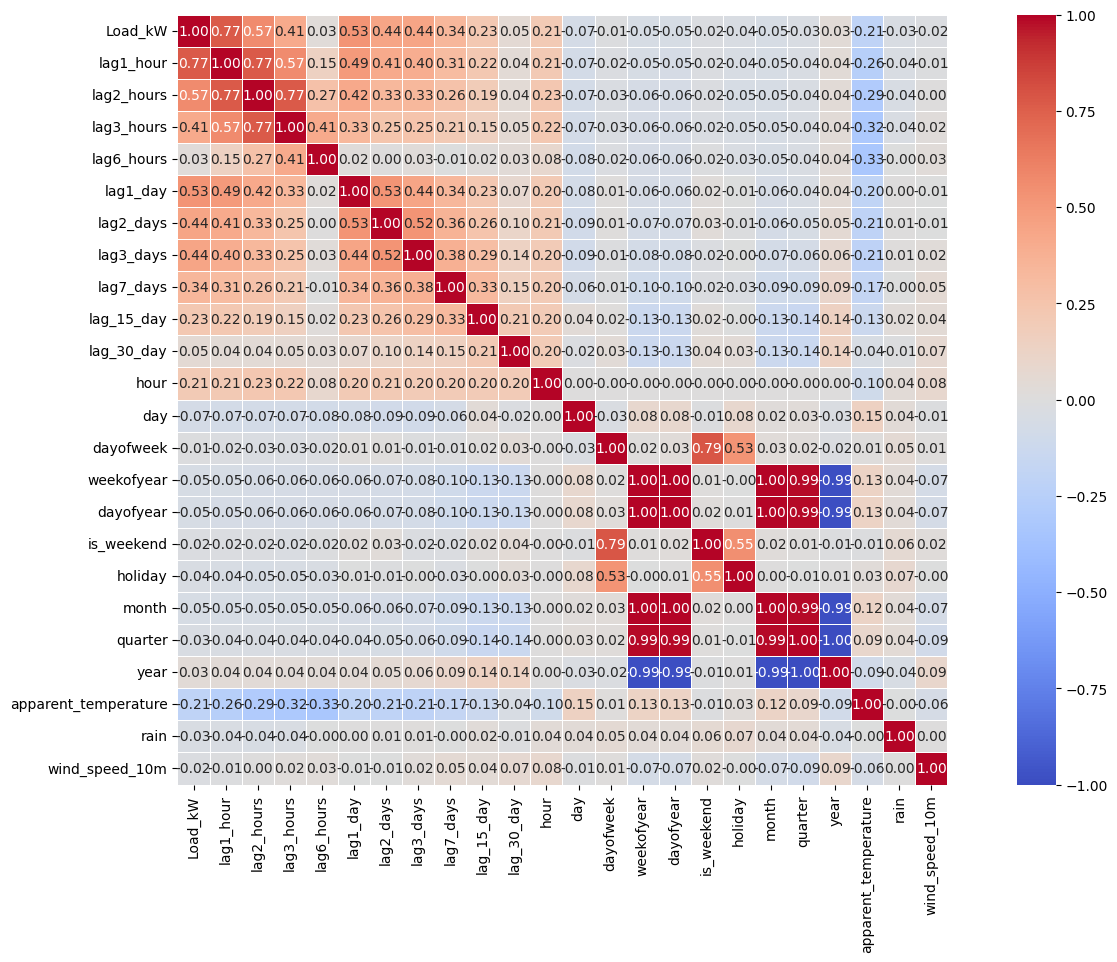

Index(['Load_kW', 'lag1_hour', 'lag2_hours', 'lag3_hours', 'lag6_hours',
       'lag1_day', 'lag2_days', 'lag3_days', 'lag7_days', 'lag_15_day',
       'lag_30_day', 'hour', 'day', 'dayofweek', 'weekofyear', 'dayofyear',
       'is_weekend', 'holiday', 'month', 'quarter', 'year',
       'apparent_temperature', 'rain', 'wind_speed_10m'],
      dtype='object')


,Load_kW,lag1_hour,lag2_hours,lag3_hours,lag6_hours,lag1_day,lag2_days,lag3_days,lag7_days,lag_15_day,lag_30_day,hour,day,dayofweek,weekofyear,dayofyear,is_weekend,holiday,month,quarter,year,apparent_temperature,rain,wind_speed_10m
creation_time,,,,,,,,,,,,,,,,,,,,,,,,
2023-10-31 00:00:00,16.9358,16.6744,17.3522,19.3026,4.0883,15.6319,19.0606,13.5442,15.3803,12.4828,19.8822,0,31,1,44,304,0,0,10,4,2023,18.9000,0.0000,12.3000
2023-10-31 01:00:00,15.7049,16.9358,16.6744,17.3522,16.1377,15.0002,21.5578,14.4414,16.5768,14.4739,19.9639,1,31,1,44,304,0,0,10,4,2023,20.0000,0.0000,14.0000
2023-10-31 02:00:00,15.1805,15.7049,16.9358,16.6744,17.3828,14.5787,23.1084,14.7871,16.5603,14.7989,20.1197,2,31,1,44,304,0,0,10,4,2023,20.3000,0.0000,13.7000
2023-10-31 03:00:00,14.9511,15.1805,15.7049,16.9358,19.3026,15.3064,23.4511,15.0699,16.4752,14.0594,20.2728,3,31,1,44,304,0,0,10,4,2023,22.9000,0.0000,12.3000
2023-10-31 04:00:00,15.3654,14.9511,15.1805,15.7049,17.3522,16.2328,25.8807,14.6961,14.1864,13.2417,23.8996,4,31,1,44,304,0,0,10,4,2023,26.2000,0.0000,11.1000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-03-30 19:00:00,10.3994,18.0048,25.6102,11.6272,6.1052,14.0658,14.8892,11.6964,35.2989,18.3511,33.5773,19,30,5,13,90,1,0,3,1,2024,21.8000,0.0000,13.0000
2024-03-30 20:00:00,11.5158,10.3994,18.0048,25.6102,0.0000,14.2439,15.9586,8.0703,19.5567,16.5481,44.7264,20,30,5,13,90,1,0,3,1,2024,20.7000,0.0000,14.8000
2024-03-30 21:00:00,12.2079,11.5158,10.3994,18.0048,6.5197,8.4875,13.6215,9.7136,9.8701,14.4486,39.1983,21,30,5,13,90,1,0,3,1,2024,19.9000,0.0000,9.5000


In [63]:
from common_functions import NPCL, common
npcl_obj = NPCL()
common_obj  = common()
testing_obj = testing()

# df1 = common_obj.add_lags(resample_df,target_col="Load_kW")
# df2 = common_obj.create_features(df1)
latitude,longitude = "27.34019480", "72.93117380"
# latitude, longitude = "28.625361","77.376214"#, 28.628059,77.378912
from_date = resample_df.first_valid_index().date()
to_date = resample_df.last_valid_index().date()
print("from_date: ",from_date,"to_date: ",to_date)
weather_df = npcl_obj.weather_data_api(latitude,longitude,from_date,to_date) # ,duration="15min"

holidays_lst= common_obj.holidays_list(from_date,to_date)
print("holidays_lst:",holidays_lst)

df_lags = testing_obj.add_lags(resample_df,target_col="Load_kW",large_data=True)
df2 = testing_obj.create_features(df_lags,lagre_data=True)
print(df2.isna().sum())
for date in holidays_lst:
    df2.loc[f"{date}", 'holiday'] = 1
# df2.fillna(0,inplace= True)
df2.dropna(inplace=True)
df3 = df2.merge(weather_df,on=["creation_time"])
# df3.drop(['creation_time'],axis=1,inplace=True)
common_obj.correlation_matrix(df3)
print(df3.columns)
df3

### feature engineering

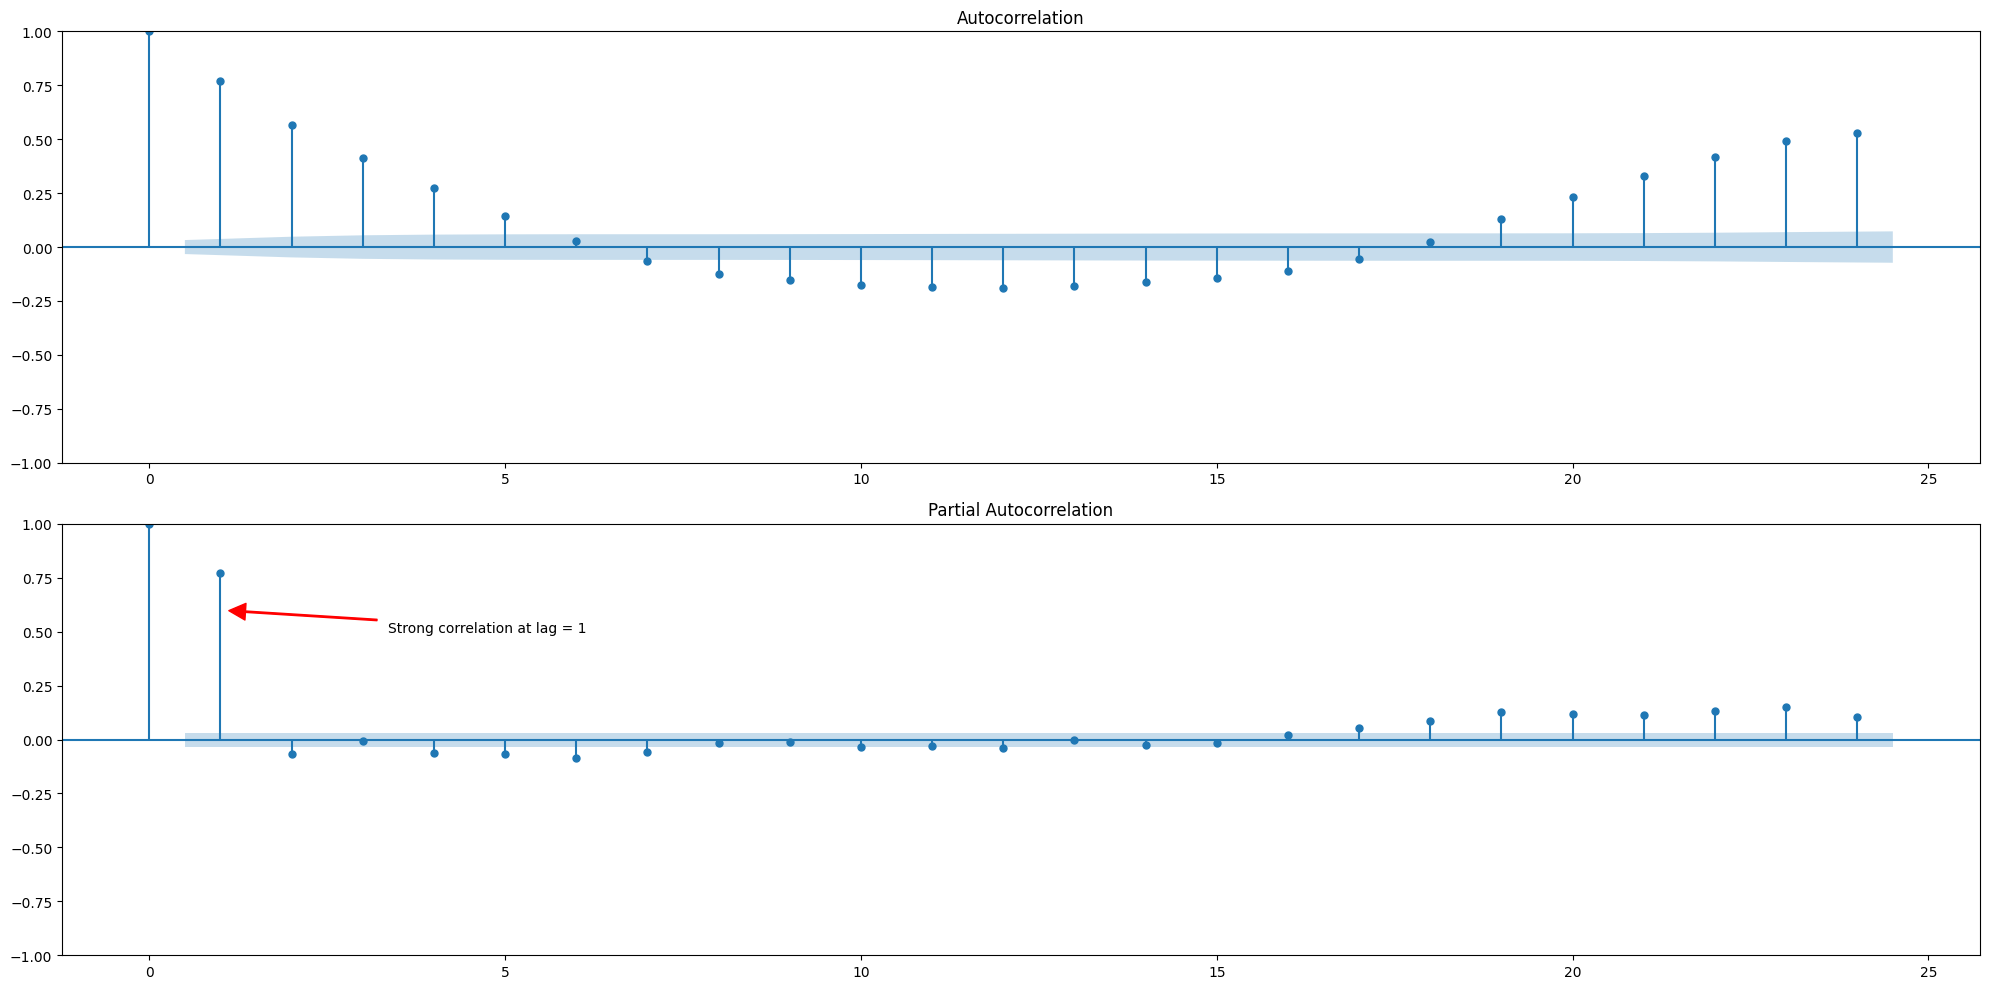

In [9]:
# from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
# import matplotlib.pyplot as plt

# lag_acf = 24
# f, ax = plt.subplots(nrows=2, ncols=1, figsize=(20, 10))
# plot_acf(df3['Load_kW'],lags=lag_acf, ax=ax[0])
# plot_pacf(df3['Load_kW'],lags=lag_acf, ax=ax[1], method='ols')

# ax[1].annotate('Strong correlation at lag = 1', xy=(1, 0.6),  xycoords='data',
#             xytext=(0.17, 0.75), textcoords='axes fraction',
#             arrowprops=dict(color='red', shrink=0.05, width=1))

# plt.tight_layout()
# plt.show()

# # plot_acf(df2['Load_kW'], lags=720)
# # plt.show()

# # plot_pacf(df2['Load_kW'], lags=720)
# # plt.show()


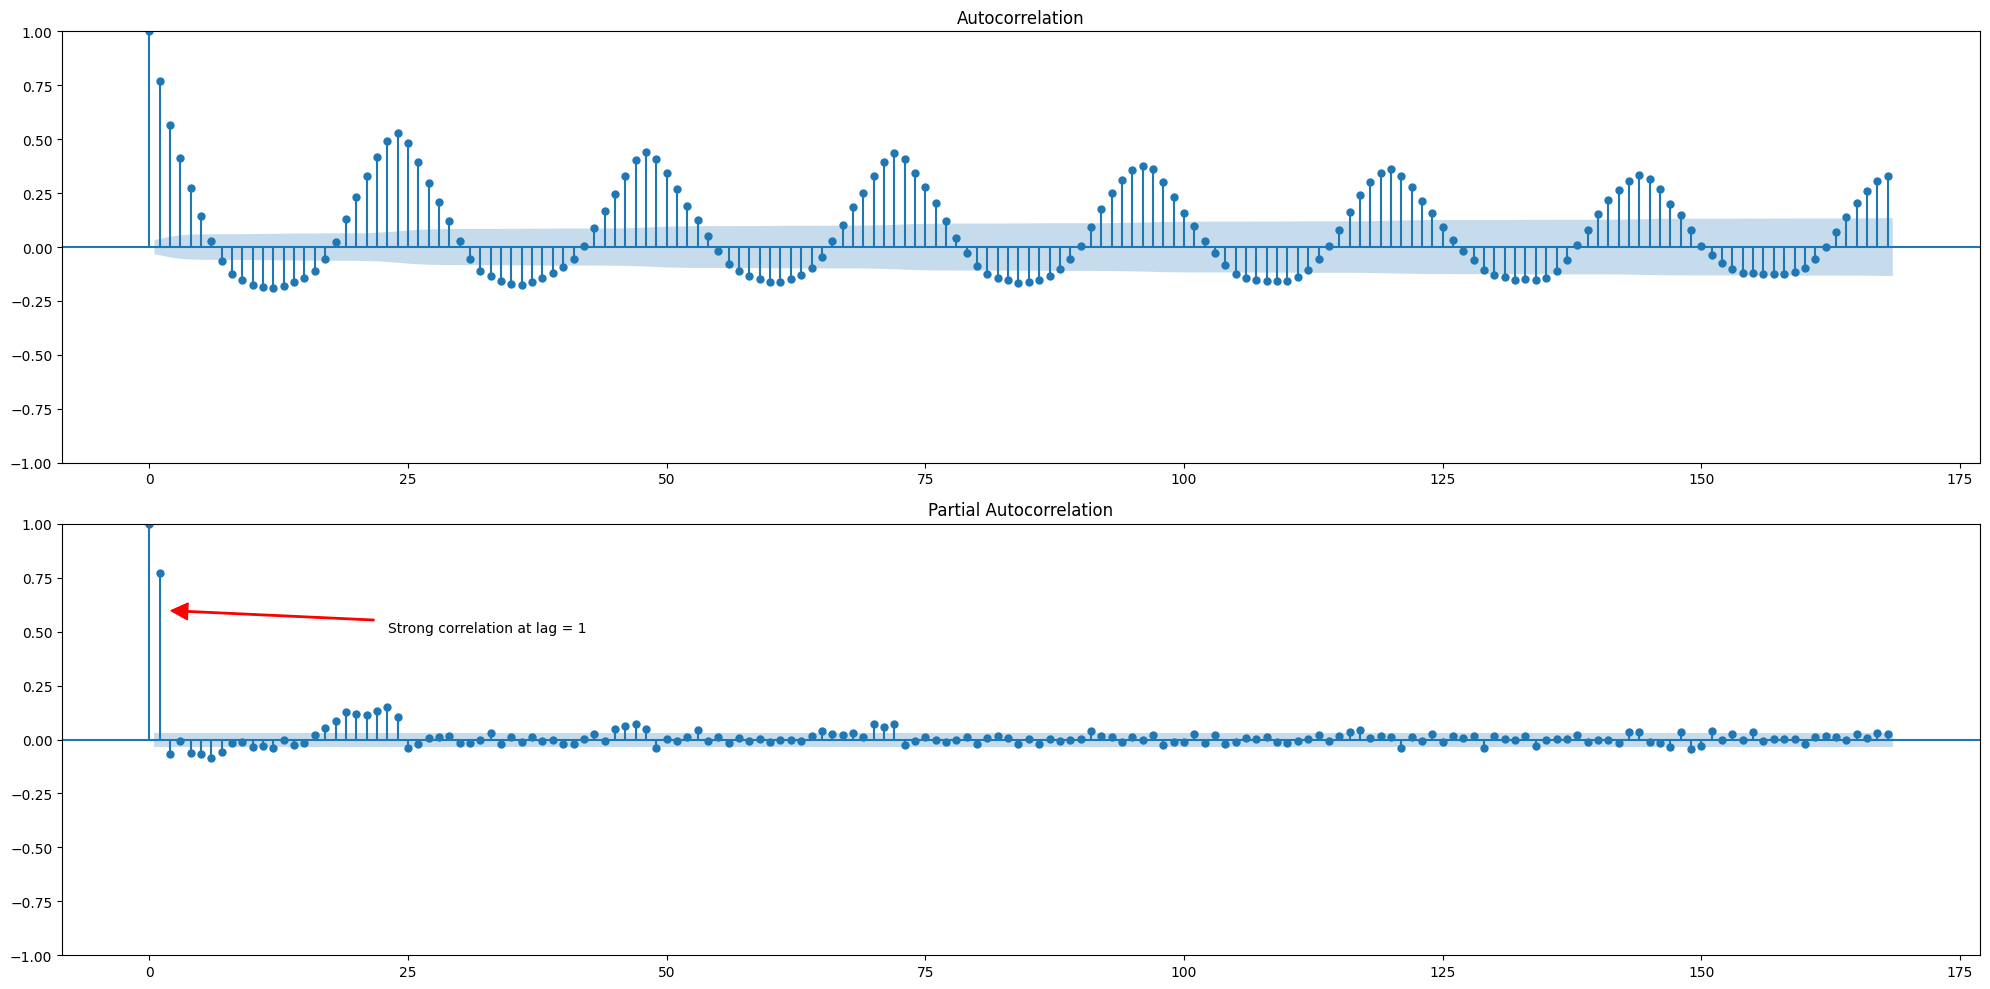

In [10]:
# lag_acf = 24*7
# f, ax = plt.subplots(nrows=2, ncols=1, figsize=(20, 10))
# plot_acf(df3['Load_kW'],lags=lag_acf, ax=ax[0])
# plot_pacf(df3['Load_kW'],lags=lag_acf, ax=ax[1], method='ols')

# ax[1].annotate('Strong correlation at lag = 1', xy=(1, 0.6),  xycoords='data',
#             xytext=(0.17, 0.75), textcoords='axes fraction',
#             arrowprops=dict(color='red', shrink=0.05, width=1))

# plt.tight_layout()
# plt.show()

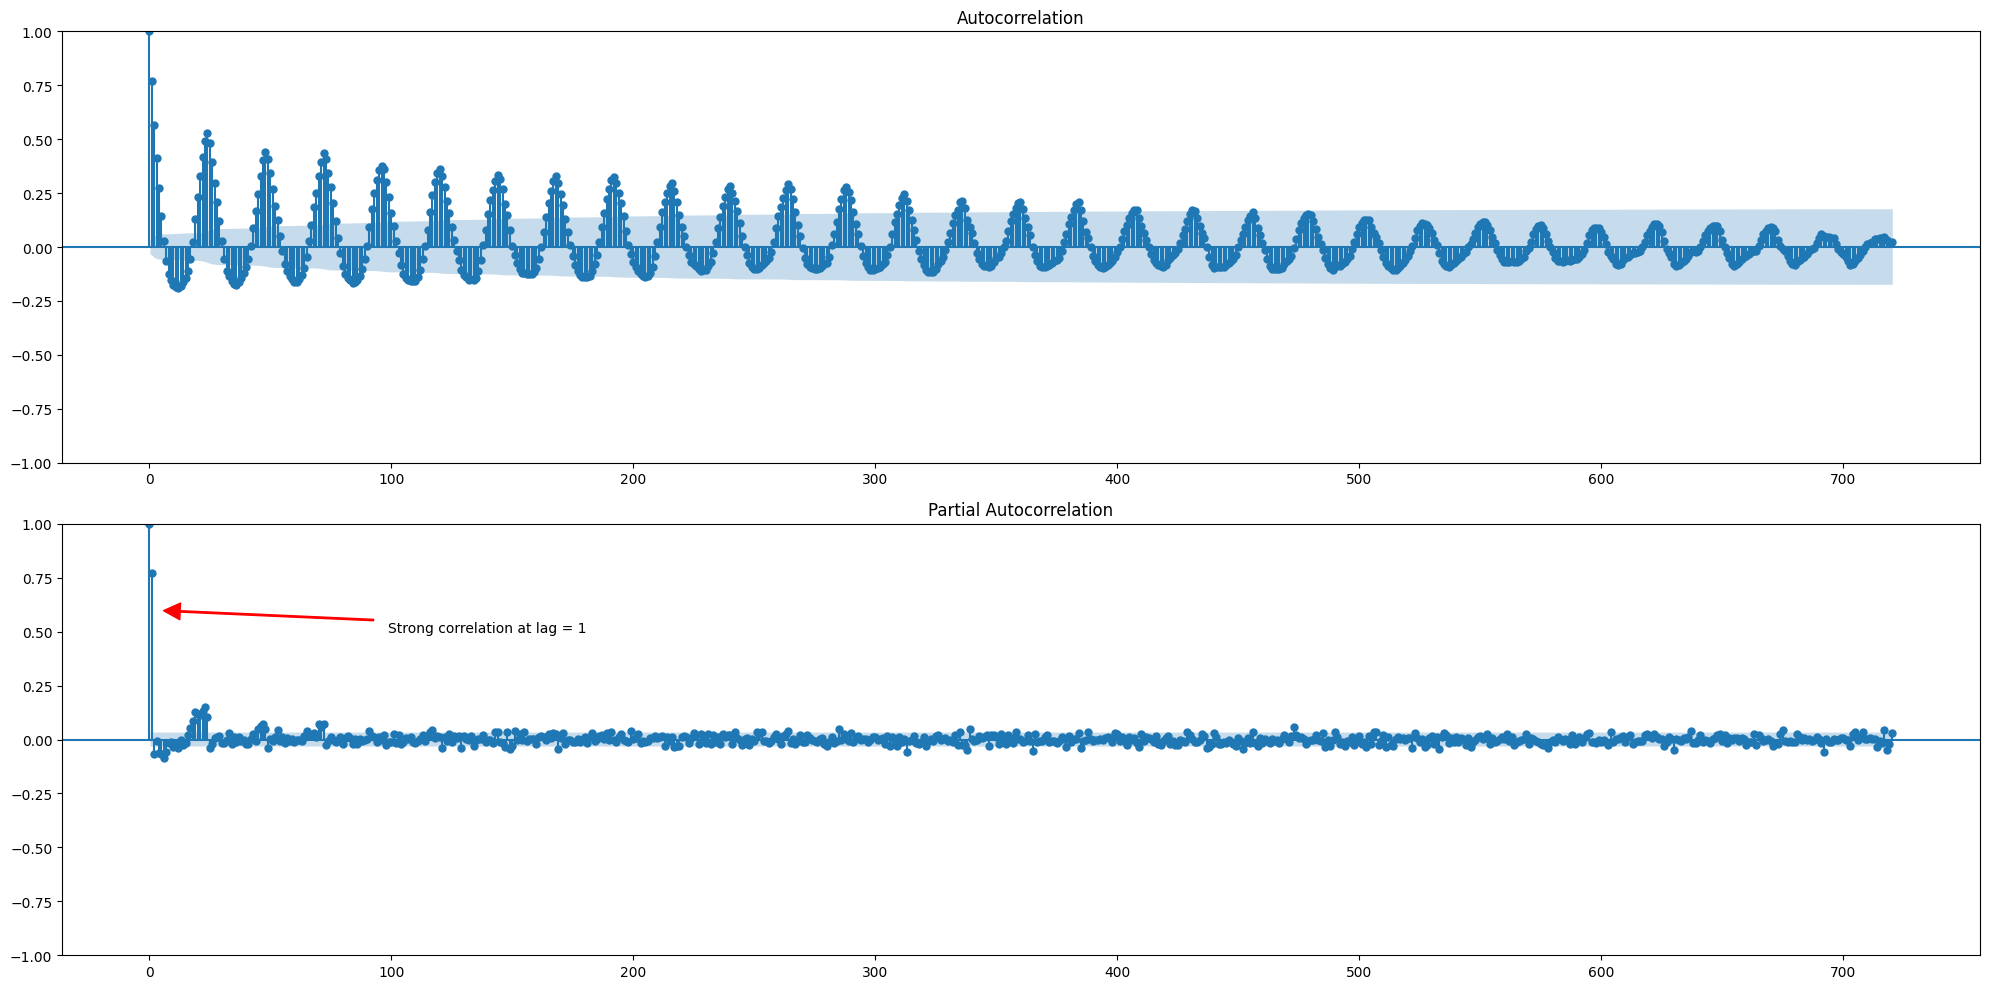

In [11]:
# lag_acf = 24*30
# f, ax = plt.subplots(nrows=2, ncols=1, figsize=(20, 10))
# plot_acf(df3['Load_kW'],lags=lag_acf, ax=ax[0])
# plot_pacf(df3['Load_kW'],lags=lag_acf, ax=ax[1], method='ols')

# ax[1].annotate('Strong correlation at lag = 1', xy=(1, 0.6),  xycoords='data',
#             xytext=(0.17, 0.75), textcoords='axes fraction',
#             arrowprops=dict(color='red', shrink=0.05, width=1))

# plt.tight_layout()
# plt.show()

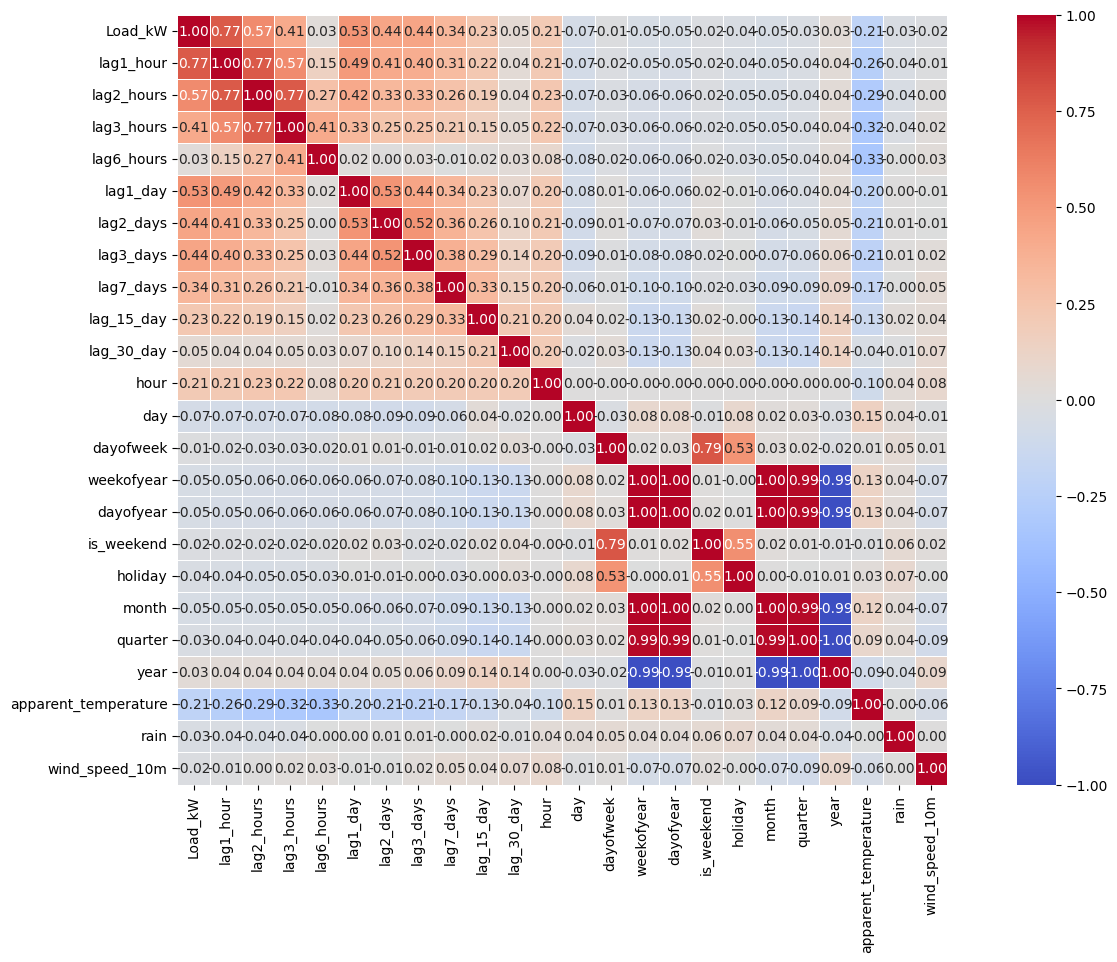

In [59]:
common_obj.correlation_matrix(df3)

In [60]:
# # # df3['rolled_load'] = df3['Load_kW'].rolling(window=4).mean()
# # # df3[['Load_kW','rolled_load']].plot()
# df3['Load_kW'] = df3['Load_kW'].rolling(window=4).mean()
# # df3[['Load_kW','rolled_load']].plot()
# df3.dropna(inplace=True)

In [64]:
# ['Load_kW', 'lag1_hour', 'lag2_hours', 'lag3_hours', 'lag6_hours','lag1_day', 'lag2_days', 'lag3_days', 'lag7_days', 'lag_15_day','lag_30_day', 'hour', 'day', 'dayofweek', 'weekofyear', 'dayofyear','is_weekend', 'holiday', 'month', 'quarter', 'year','apparent_temperature', 'rain', 'wind_speed_10m']
dff = df3[['Load_kW', 'lag1_hour', 'lag2_hours', 'lag3_hours', 'lag1_day', 'lag7_days', 'day', 'dayofweek', 'dayofyear','apparent_temperature', 'rain', 'wind_speed_10m']]
dff['Load_kW'] = dff['Load_kW'].rolling(window=4).mean()
# df3[['Load_kW','rolled_load']].plot()
dff.dropna(inplace=True)

#### test_dataset split for final testing

In [65]:
# train_dataset ,test_dataset = final_df
n = len(dff)
train_dataset, test_dataset = dff[0:int(n*0.9)].copy(),dff[int(n*0.9):].copy()
print(f"train_dataset,test_dataset: {train_dataset.shape,test_dataset.shape}")

test_features = test_dataset.copy()
test_label = test_features.pop("Load_kW")
print(f"test_features,test_label: {test_features.shape,test_label.shape}")

train_dataset,test_dataset: ((3280, 12), (365, 12))
test_features,test_label: ((365, 11), (365,))


#### scaling

In [66]:
# from sklearn.compose import ColumnTransformer
# from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
# df_feature = df3.copy() 
# df_label = df_feature.pop("Load_kW")
# # ['Load_kW', 'lag1_hour', 'lag2_hours', 'lag3_hours', 'lag6_hours','lag1_day', 'lag2_days', 'lag3_days', 'lag7_days', 'lag_15_day','lag_30_day', 'lag_45_day', 'hour', 'day', 'dayofweek', 'weekofyear','dayofyear', 'is_weekend', 'holiday', 'month', 'quarter', 'year','apparent_temperature', 'rain', 'wind_speed_10m']
# # Define which features should use which scaler
# scaler = ColumnTransformer(transformers=[
#     ('minmax', MinMaxScaler(), ['lag1_hour', 'lag2_hours', 'lag3_hours', 'lag6_hours','lag1_day', 'lag2_days', 'lag3_days', 'lag7_days', 'lag_15_day','lag_30_day', 'hour', 'day', 'dayofweek', 'weekofyear','dayofyear', 'is_weekend', 'holiday', 'month', 'quarter', 'year','apparent_temperature', 'wind_speed_10m']),  # Normalize lag features
#     # ('standard', StandardScaler(), ['apparent_temperature', 'wind_speed_10m']),  # Standardize weather features
#     ('robust', RobustScaler(), ['rain'])  # Robust scale for rain and target
# ], remainder='passthrough')

# # Fit and transform on training data
# df_scaled = pd.DataFrame(scaler.fit_transform(df_feature),columns=df_feature.columns)
# df_scaled['Load_kW'] = np.array(df_label)
# df_scaled.describe()

In [67]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler

target_variable = ["Load_kW"]
# Exclude the "Load_kW" column from features to normalize
features_to_normalize = [col for col in train_dataset.columns if col not in target_variable]
# print(features_to_normalize)
feature_scaler = MinMaxScaler()
# feature_scaler = StandardScaler()
train_dataset[features_to_normalize] = feature_scaler.fit_transform(train_dataset[features_to_normalize])
train_dataset


,Load_kW,lag1_hour,lag2_hours,lag3_hours,lag1_day,lag7_days,day,dayofweek,dayofyear,apparent_temperature,rain,wind_speed_10m
creation_time,,,,,,,,,,,,
2023-10-31 03:00:00,15.6931,0.2826,0.2923,0.3152,0.2849,0.3067,1.0000,0.1667,0.8324,0.6867,0.0000,0.2841
2023-10-31 04:00:00,15.3005,0.2783,0.2826,0.2923,0.3022,0.2641,1.0000,0.1667,0.8324,0.7911,0.0000,0.2564
2023-10-31 05:00:00,15.1760,0.2860,0.2783,0.2826,0.2215,0.2651,1.0000,0.1667,0.8324,0.8829,0.0000,0.2564
2023-10-31 06:00:00,15.8253,0.2831,0.2860,0.2783,0.2423,0.1937,1.0000,0.1667,0.8324,0.9525,0.0000,0.2263
2023-10-31 07:00:00,15.2855,0.3309,0.2831,0.2860,0.3557,0.3465,1.0000,0.1667,0.8324,0.9810,0.0000,0.1986
...,...,...,...,...,...,...,...,...,...,...,...,...
2024-03-15 14:00:00,33.3650,0.7325,0.6375,0.4583,0.7658,0.6376,0.4667,0.6667,0.2033,0.6456,0.0000,0.2471
2024-03-15 15:00:00,36.2450,0.6560,0.7325,0.6375,0.4592,0.6584,0.4667,0.6667,0.2033,0.5949,0.0000,0.3002
2024-03-15 16:00:00,34.8058,0.6728,0.6560,0.7325,0.4161,0.6492,0.4667,0.6667,0.2033,0.5633,0.0000,0.3048


In [68]:
train_dataset.columns

Index(['Load_kW', 'lag1_hour', 'lag2_hours', 'lag3_hours', 'lag1_day',
       'lag7_days', 'day', 'dayofweek', 'dayofyear', 'apparent_temperature',
       'rain', 'wind_speed_10m'],
      dtype='object')

#### train test split for training and validation  and feature and label extractions

In [69]:
# train_dataset ,test_dataset = final_df
n = len(train_dataset)
train_df, val_df = train_dataset[0:int(n*0.9)].copy(),train_dataset[int(n*0.9):].copy()
print(f"train_dataset,val_dataset: {train_df.shape,val_df.shape}")

# train 
train_features = train_df.copy()   
train_label = train_features.pop('Load_kW')
print(f"train_features shape: {train_features.shape}\ntrain_label shape: {train_label.shape}")

# val
val_features = val_df.copy()   
val_label = val_features.pop('Load_kW')
print(f"val_feature shape: {val_features.shape}\nval_label shape: {val_label.shape}")

train_dataset,val_dataset: ((2952, 12), (328, 12))
train_features shape: (2952, 11)
train_label shape: (2952,)
val_feature shape: (328, 11)
val_label shape: (328,)


#### prediction plotting

In [70]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

def plot_prediction(actual, predicted):
    rmse = sqrt(mean_squared_error(actual, predicted))
    print("\nModel Power Evaluation")
    # print("Mean Squared Error (MSE):", mean_squared_error(actual, predicted))
    print("Mean Absolute Error (MAE):", mean_absolute_error(actual, predicted))
    print(f"Root Mean Squared Error (RMSE): {rmse}")
    print("R-squared:", r2_score(actual, predicted))

    # Scatter plot
    plt.figure(figsize=(10, 6))
    # Plot actual values in red
    plt.plot(range(len(actual)), actual, color='red', label='Actual Power')
    # Plot predicted values in blue
    plt.plot(range(len(predicted)), predicted, color='blue', label='Predicted Power')
    # Adding labels and title
    plt.xlabel('Time')
    plt.ylabel('load')
    plt.title('Actual vs Predicted load')
    plt.legend()
    plt.tight_layout()
    plt.show()

## XGboost model

Initial Train Score 0.9985803031543387
Fitting 5 folds for each of 10 candidates, totalling 50 fits
Best Parameters: {'subsample': 0.1, 'reg_lambda': 0.1, 'reg_alpha': 0.2, 'n_estimators': 600, 'max_depth': 40, 'learning_rate': 0.03, 'colsample_bytree': 0.6}
TRAIN SCORE with hyperparameters tunning: 0.9927793307313163

Model Power Evaluation
Mean Absolute Error (MAE): 1.3296139635548478
Root Mean Squared Error (RMSE): 1.9460166679988342
R-squared: 0.9468826472240461


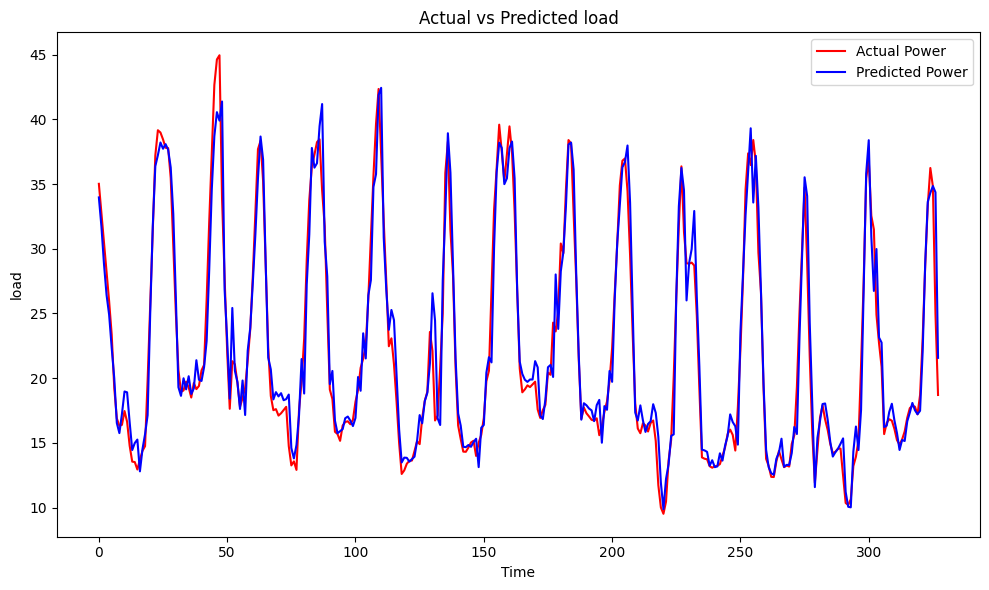


Model Power Evaluation
Mean Absolute Error (MAE): 1.1128461762448376
Root Mean Squared Error (RMSE): 1.5789793263511778
R-squared: 0.9386784844560863


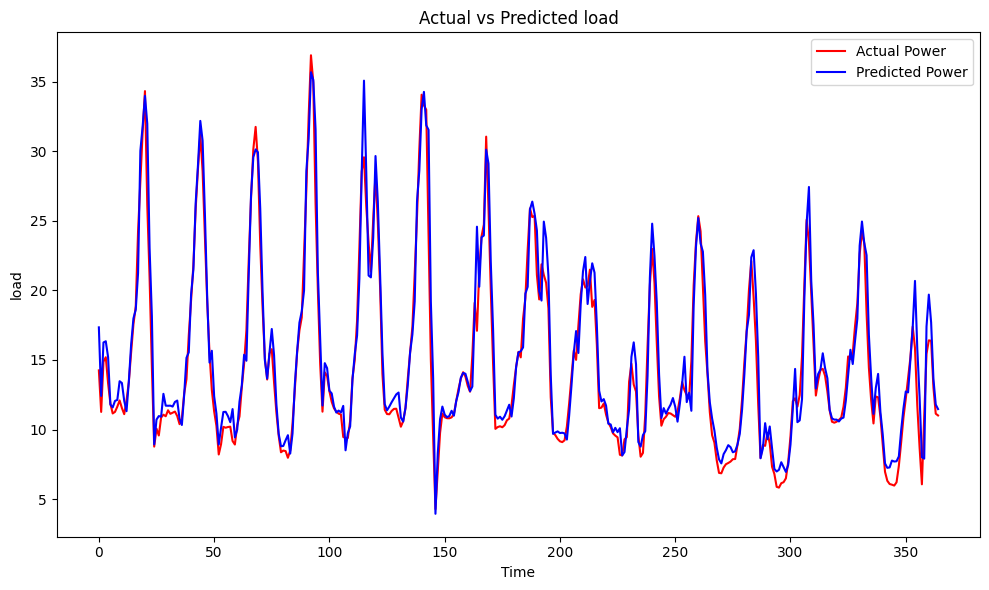

In [71]:
# train_features, train_label = train_featu
xgb_model = XGBRegressor()
xgb_model.fit(train_features, train_label)

# Calculate and print model evaluation metrics for this sensor
train_score = xgb_model.score(train_features, train_label)
print(f"Initial Train Score {train_score}")

# Perform hyperparameter tuning using RandomizedSearchCV
param_grid = {
        "n_estimators" : [200, 250, 300, 350,400, 450, 500, 550, 600, 650],       
        "max_depth": [ 10, 15, 20, 25, 30, 35, 40], # 1, 2, 3, 5,
        "learning_rate": [0.0001, 0.001,0.01, 0.1, 0.3, 0.02, 0.2, 1, 0.03],
        "subsample": [0.1, 0.5, 0.7, 0.3, 0.2,0.4, 0.6],
        "colsample_bytree":  [0.1, 0.5, 0.7, 0.3, 0.2,0.4,0.6],
        'reg_alpha': [0.01, 0.1, 0.3, 0.02, 0.2, 1, 0.03],
        'reg_lambda': [0.01, 0.1, 0.5, 1.0],  # Add L2 regularization

    # 'n_estimators': [100, 200, 300, 400, 500],
    # 'max_depth': [3, 5, 7, 10],
    # 'learning_rate': [0.01, 0.05, 0.1, 0.2],
    # 'subsample': [0.5, 0.7, 0.8, 1.0],
    # 'colsample_bytree': [0.5, 0.7, 1.0],
    # 'reg_alpha': [0.01, 0.1, 0.5, 1.0]

        # "n_estimators": [200, 250, 300, 350,400, 450, 500],
        # "max_depth": [3,5,10,15, 20, 25,30],
        # "learning_rate": [0.01, 0.1, 0.3, 0.02, 0.2, 1, 0.03],
        # "subsample": [0.1, 0.5, 0.7, 0.3, 0.2,0.4,0.6],
        # "colsample_bytree":  [0.1, 0.5, 0.7, 0.3, 0.2,0.4,0.6],
        # 'reg_alpha': [0.01, 0.1, 0.3, 0.02, 0.2, 1, 0.03],
        }

# random_search = RandomizedSearchCV(xgb_model,
#                                     param_distributions=param_grid,
#                                     n_iter=5,
#                                     scoring='neg_mean_squared_error',
#                                     cv=5,
#                                     random_state=100)

# # Fit the RandomizedSearchCV to the data
# # random_search.fit(X_train, y_train)
# random_search.fit(train_features, train_label)
from sklearn.model_selection import TimeSeriesSplit

tscv = TimeSeriesSplit(n_splits=5)
random_search = RandomizedSearchCV(
    estimator=xgb_model, 
    param_distributions=param_grid, 
    n_iter=10,
    scoring='neg_mean_squared_error',
    cv=tscv,  # Use time series split
    verbose=1,
    random_state=100
)

random_search.fit(train_features, train_label)


# Get the best parameters
best_params = random_search.best_params_
print(f"Best Parameters: {best_params}")

# Train the model with the best parameters
best_xgb_model = XGBRegressor(n_estimators=best_params['n_estimators'],
                                max_depth=best_params['max_depth'],
                                learning_rate=best_params['learning_rate'],
                                subsample=best_params['subsample'],
                                colsample_bytree=best_params['colsample_bytree'],
                                reg_alpha=best_params['reg_alpha'],
                                base_score=0.5,
                                booster='gbtree',
                                # reg_lambda=best_params['reg_lambda'],
                                objective='reg:squarederror')
best_xgb_model.fit(train_features, train_label)

# Evaluate the model on the test set
test_score = best_xgb_model.score(train_features, train_label)
print(f"TRAIN SCORE with hyperparameters tunning: {test_score}")

best_xgb_model
plot_prediction(val_label,best_xgb_model.predict(val_features))
plot_prediction(test_label,best_xgb_model.predict(feature_scaler.transform(test_features)))

Fitting 5 folds for each of 10 candidates, totalling 50 fits
Best Parameters: {'subsample': 1.0, 'reg_lambda': 0.1, 'reg_alpha': 0.5, 'n_estimators': 100, 'max_depth': 5, 'learning_rate': 0.1, 'colsample_bytree': 0.7}
TRAIN SCORE with hyperparameters tunning: 0.9884400783845251

Model Power Evaluation
Mean Absolute Error (MAE): 1.2121782093373412
Root Mean Squared Error (RMSE): 1.8275715882500263
R-squared: 0.9531518865282215


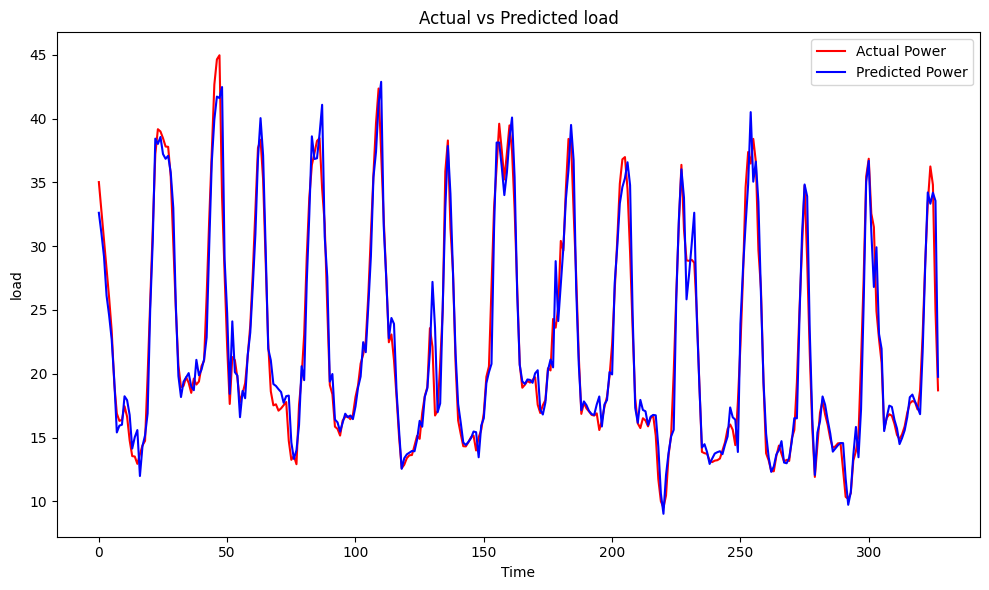


Model Power Evaluation
Mean Absolute Error (MAE): 1.0059818933439624
Root Mean Squared Error (RMSE): 1.4956693284653848
R-squared: 0.9449786594269256


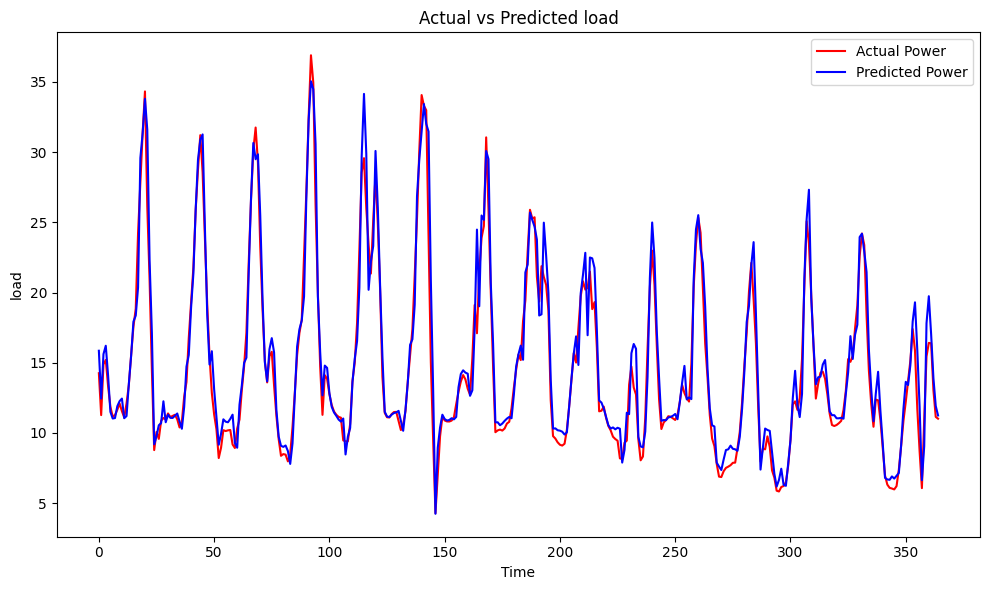

In [72]:
param_grid = {
    'n_estimators': [100, 200, 300, 400, 500],
    'max_depth': [3, 5, 7, 10],
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'subsample': [0.5, 0.7, 0.8, 1.0],
    'colsample_bytree': [0.5, 0.7, 1.0],
    'reg_alpha': [0.01, 0.1, 0.5, 1.0],
    'reg_lambda': [0.01, 0.1, 0.5, 1.0]  # Add L2 regularization

}

tscv = TimeSeriesSplit(n_splits=5)
random_search = RandomizedSearchCV(
    estimator=xgb_model, 
    param_distributions=param_grid, 
    n_iter=10,
    scoring='neg_mean_squared_error',
    cv=tscv,  # Use time series split
    verbose=1,
    random_state=100
)
# Perform hyperparameter tuning using RandomizedSearchCV
xgb_model = XGBRegressor(objective='reg:squarederror', random_state=42)
random_search = RandomizedSearchCV(
    estimator=xgb_model, 
    param_distributions=param_grid, 
    n_iter=10,  # Try more iterations for better results
    scoring='neg_mean_squared_error',
    cv=5,
    verbose=1,
    random_state=100)

# Fit the random search on training data
random_search.fit(train_features, train_label)

# Best parameters
best_params = random_search.best_params_
print("Best Parameters:", best_params)

# Train a new XGBoost model with the best parameters
best_xgb_model = XGBRegressor(**best_params)
best_xgb_model.fit(train_features, train_label)
test_score = best_xgb_model.score(train_features, train_label)
print(f"TRAIN SCORE with hyperparameters tunning: {test_score}")

best_xgb_model
plot_prediction(val_label,best_xgb_model.predict(val_features))
plot_prediction(test_label,best_xgb_model.predict(feature_scaler.transform(test_features)))

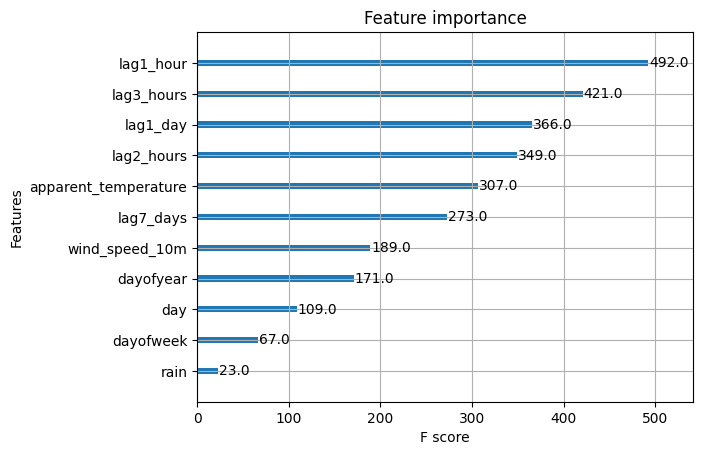

In [73]:
import matplotlib.pyplot as plt
from xgboost import plot_importance

# Plot feature importance
plot_importance(best_xgb_model)
plt.show()


### random forrest regressor

Initial Train Score 0.9950531785461022
Fitting 5 folds for each of 10 candidates, totalling 50 fits
Best Parameters: {'n_jobs': -1, 'n_estimators': 300, 'min_samples_split': 10, 'min_samples_leaf': 2, 'max_features': 'sqrt', 'max_depth': None, 'bootstrap': False}
TRAIN SCORE with hyperparameters tunning: 0.9938297759350833

Model Power Evaluation
Mean Absolute Error (MAE): 1.2704906319067402
Root Mean Squared Error (RMSE): 1.8473201244090602
R-squared: 0.9521339451527395


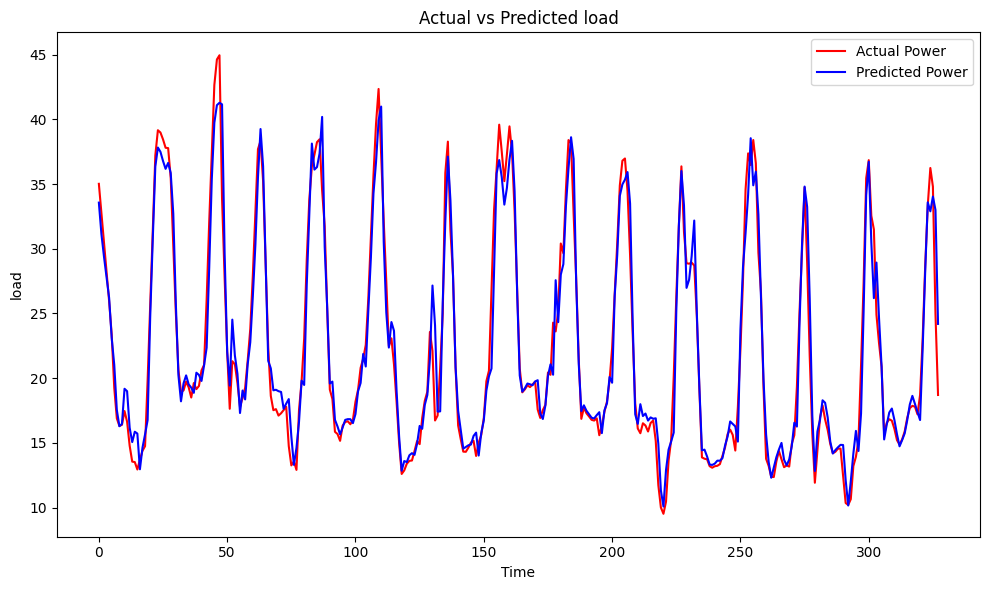


Model Power Evaluation
Mean Absolute Error (MAE): 1.2481984807683963
Root Mean Squared Error (RMSE): 1.690933396624403
R-squared: 0.9296744729575684


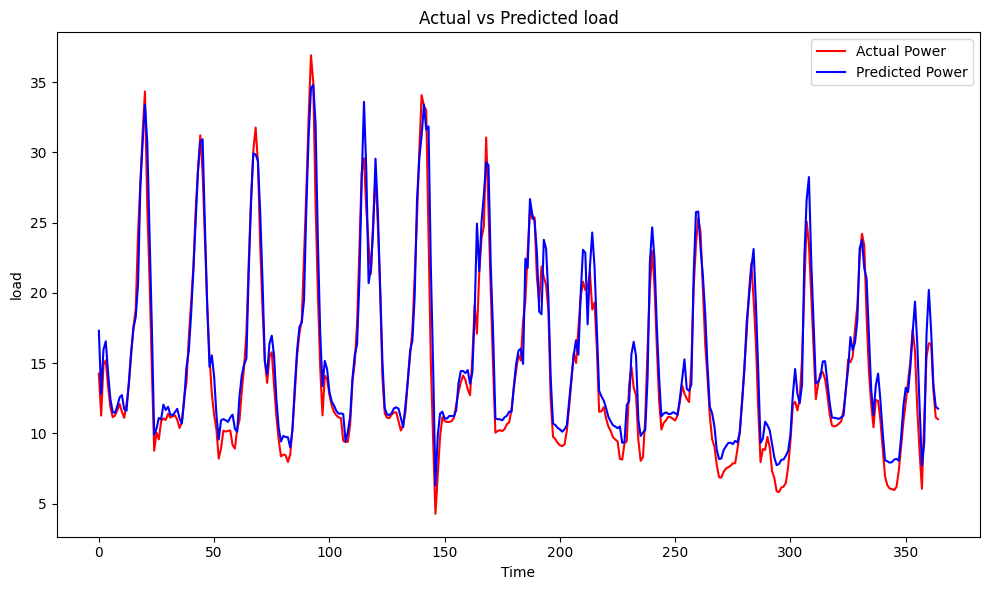

In [74]:
# Initialize the RandomForestRegressor model

RFRmodel = RandomForestRegressor()
RFRmodel.fit(train_features,train_label)
# Calculate and print model evaluation metrics for this sensor
train_score = RFRmodel.score(train_features, train_label)
print(f"Initial Train Score {train_score}")

param_grid = {
                'n_estimators': [100, 200, 300, 500, 1000],
                'max_depth': [10, 20, 30, 50, None],
                'min_samples_split': [2, 5, 10],
                'min_samples_leaf': [1, 2, 5, 10],
                'max_features': ['auto', 'sqrt', 'log2'],
                'bootstrap': [True, False],
                'n_jobs': [-1]  # Use all cores for faster training
            }


# Perform hyperparameter tuning using RandomizedSearchCV
random_search = RandomizedSearchCV(estimator=RFRmodel, param_distributions=param_grid, 
                                n_iter=10, cv=5, verbose=2, 
                                scoring='neg_mean_squared_error', n_jobs=-1)

# Fit the RandomizedSearchCV to the data
random_search.fit(train_features, train_label)

# Get the best parameters
best_params = random_search.best_params_
print(f"Best Parameters: {best_params}")

# Train the model with the best parameters
best_RFRmodel = RandomForestRegressor(**best_params, random_state=42)
best_RFRmodel.fit(train_features, train_label)
test_score = best_RFRmodel.score(train_features, train_label)
print(f"TRAIN SCORE with hyperparameters tunning: {test_score}")
plot_prediction(val_label,best_RFRmodel.predict(val_features))

plot_prediction(test_label,best_RFRmodel.predict(feature_scaler.transform(test_features)))

#### deep learning (LSTM)

In [75]:
def reshape_fn(dataset):
    return np.array(dataset).reshape(((dataset.shape[0]),1,dataset.shape[1]))

(2952, 1, 11)
(328, 1, 11)
(365, 1, 11)
Epoch 1/100
47/47 [==============================] - 6s 40ms/step - loss: 608.6235 - val_loss: 498.5311
Epoch 2/100
47/47 [==============================] - 1s 20ms/step - loss: 394.2254 - val_loss: 209.5053
Epoch 3/100
47/47 [==============================] - 1s 17ms/step - loss: 178.8918 - val_loss: 111.1923
Epoch 4/100
47/47 [==============================] - 1s 17ms/step - loss: 122.5067 - val_loss: 83.2672
Epoch 5/100
47/47 [==============================] - 1s 19ms/step - loss: 102.4376 - val_loss: 71.6918
Epoch 6/100
47/47 [==============================] - 1s 19ms/step - loss: 92.7642 - val_loss: 66.5263
Epoch 7/100
47/47 [==============================] - 1s 18ms/step - loss: 87.7616 - val_loss: 63.7409
Epoch 8/100
47/47 [==============================] - 1s 19ms/step - loss: 84.0900 - val_loss: 61.1339
Epoch 9/100
47/47 [==============================] - 1s 18ms/step - loss: 81.4870 - val_loss: 57.4870
Epoch 10/100
47/47 [==============

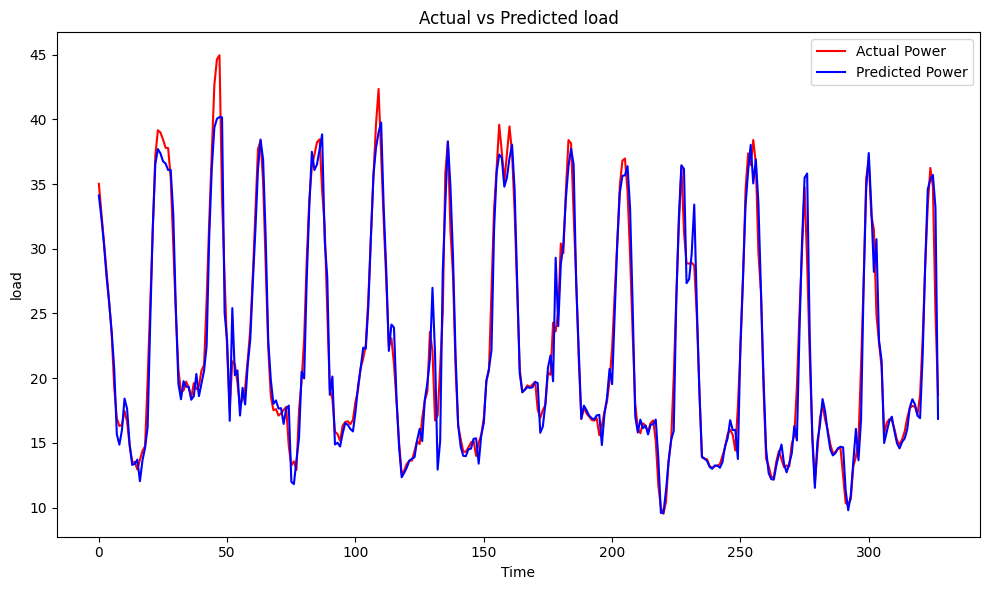

12/12 [==============================] - 0s 5ms/step

Model Power Evaluation
Mean Absolute Error (MAE): 1.112439264090737
Root Mean Squared Error (RMSE): 1.627095100769393
R-squared: 0.9348842770073944


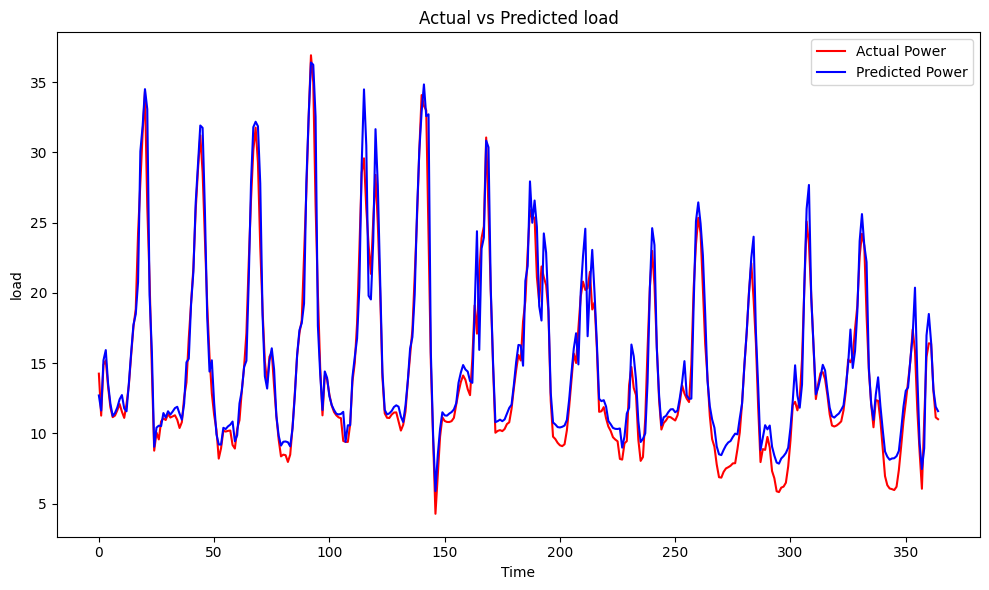

In [76]:
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import Sequential
from tensorflow.keras.layers import LSTM, Dropout, Dense
from tensorflow.keras.callbacks import EarlyStopping

# # Reshaping data for LSTM (LSTM requires 3D shape: [samples, time_steps, features])
reshaped_train_features = np.array(train_features).reshape((train_features.shape[0], 1, train_features.shape[1]))
reshaped_val_features = np.array(val_features).reshape((val_features.shape[0], 1, val_features.shape[1]))
reshaped_test_features = np.array(test_features).reshape((test_features.shape[0], 1, test_features.shape[1]))
print(reshaped_train_features.shape)
print(reshaped_val_features.shape)
print(reshaped_test_features.shape)

# Build LSTM model with increased dropout and L2 regularization
lstm_model2 = Sequential([
    
    # Adding LSTM layers with increased dropout
    LSTM(units=64, return_sequences=True, input_shape=(reshaped_train_features.shape[1], reshaped_train_features.shape[2])),
    Dropout(0.3),  # Increased dropout
    LSTM(units=64, return_sequences=False),
    Dropout(0.3),  # Increased dropout
    # Adding dense output layer with L2 regularization
    Dense(units=1, kernel_regularizer=l2(0.01))  # L2 regularization
])

# Compile the model
lstm_model2.compile(optimizer=Adam(learning_rate=0.001), loss='mean_squared_error'
)

# Define early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Train the model with early stopping
history = lstm_model2.fit(reshaped_train_features, train_label, epochs=500, batch_size=64, 
                         validation_data=(reshaped_val_features, val_label), 
                         callbacks=[early_stopping])

plot_prediction(val_label, lstm_model2.predict(reshaped_val_features))
# plot_prediction(val_label, xgb_model.predict(val_features))
plot_prediction(test_label, lstm_model2.predict(reshape_fn(feature_scaler.transform(test_features))))